<div style="text-align: center;padding-top:10px;padding-bottom:10px">
    <a href="https://geostatisticslessons.com/" target="_blank" style="color:#93c6c7" >
    <img src="https://geostatisticslessons.com/favicon-96x96.png" alt="Geostatistics Lessons Link" style="width:100px">
    </a>
</div>

<div style="text-align: center">
    <h1 style="color:#00797C;padding-bottom:0px">Choosing the Discretization Level for Block Property Estimation</h1>
    <h2 style="color:#00797C;padding-bottom:20px">A Companion Notebook to Geostatistics Lessons</h2>    
</div>

<p class="author" style="padding: 0;"><center><b>Haoze Zhang and Ryan Barnett</b></center></p>
<p class="date" style="padding: 0;"><center><b>August 8, 2025</b></center></p>

---

# Outline

The following notebook provides a demonstration of theory presented in [Choosing the Discretization Level for Block Property Estimation](https://geostatisticslessons.com/lessons/discretization). The following steps are used, where the first section is longer than subsequent sections since it develops functions for more compact re-use:

1. **Basic 2D Example**
    - Initialize a variogram and 100x100 2D grid that represents a single block
    - Generate realizations of the block, before sampling it at varying discretization levels
    - Examine the error associated with differing discretizations, comparing the sample average against the underlying exhaustive true average
3. **Block Dimension vs. Discretization Error**
    - Repeat the workflow from Section 1 on 1D and 3D grids
    - Compare how error varies with changing block dimension as a function of discretization level
4. **Spatial Correlation vs. Discretization Error**
    - Repeat the workflow from Section 1 using variograms with widely varying ranges
    - Compare how error varies with changing spatial correlation as a function of discretization level
5. **Closing Comments**

---

Import required packages:

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from copy import deepcopy
import rmsp
from itertools import product

Activate Resource Modeling Solutions Platform (RMSP) license

In [22]:
rmsp.activate()
rmsp.GlobalParams['core.enable_beta'] = True
rmsp.GlobalParams['plotting.grid'] = True

License clr9l43ma0hnhn9ufg0397yqy checked out by ryan@resmodsol.com to clhpc9e08024vlb2mj25gvz0b expires in 43 minutes. RMSP is up to date!


--- 
# Basic 2D Example

Note that functions are defined in this section for compact re-use in later sections. The described purposes of these functions are important, but their implementation details could be ignored without loss of understanding on the main points.
## Initialize a variogram

Define an isotropic variogram model. The parameters are stored in a dictionary for re-use in a subsequent section.

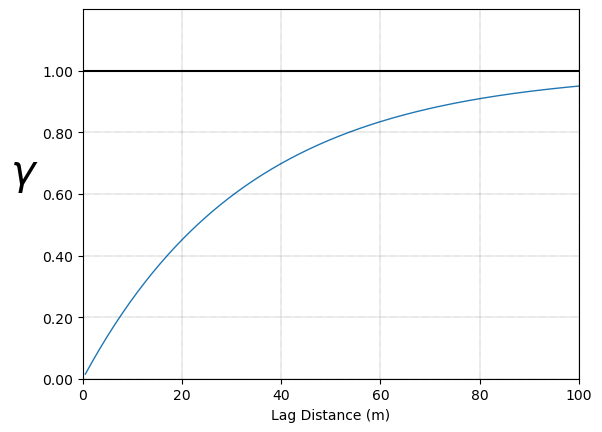

In [23]:
vario_params = dict(
    num_struct=1,
    nugget=0.0,
    shapes='exponential',
    var_contribs=[1.0],
    angles=[0.0] * 3,
    ranges=[100.0] * 3
)
vario_model = rmsp.VarioModel.from_params(**vario_params)
_ = vario_model.plot(xlim=(0, 100))

## Initialize block discretization

A 2D grid consisting of 100 evenly spaced 1m nodes in each dimension is created. When examining the effect of discretization, this grid represents one estimation block of $(100m)^2$. That is, the average of 100x100 discretized nodes represents the underlying block value. The discretization range that we will test is from 1 to 15. For example, when the discretization is two, 2x2 equally spaced points are extracted and the average value of the four points will represent the $(100m)^2$ block estimation.

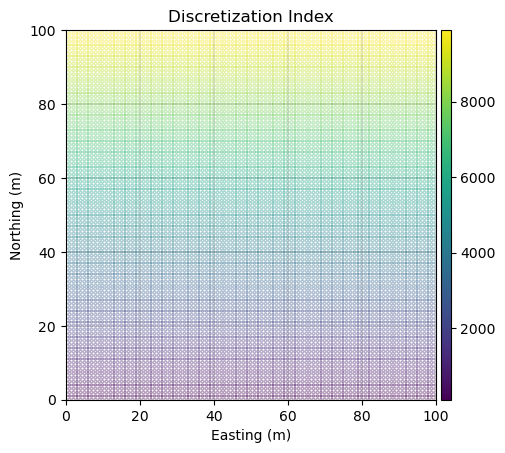

In [24]:
grid_2d = rmsp.GridData(
    griddef=rmsp.GridDef(
        xcmin=0.5,
        ycmin=0.5,
        zcmin=0.5,
        usize=1.0,
        vsize=1.0,
        zsize=1.0,
        nu=100,
        nv=100,
        nz=1,
        azimuth_deg=0.0,
        blockindices='full'
    )
)
grid_2d['Discretization Index'] = grid_2d.index
_ = grid_2d.sectionplot('Discretization Index', block_outline=True)

Pre-calculate the grid indices that uniformly sample the 'block' at discretizations levels of 1 to 15 (in each dimension).

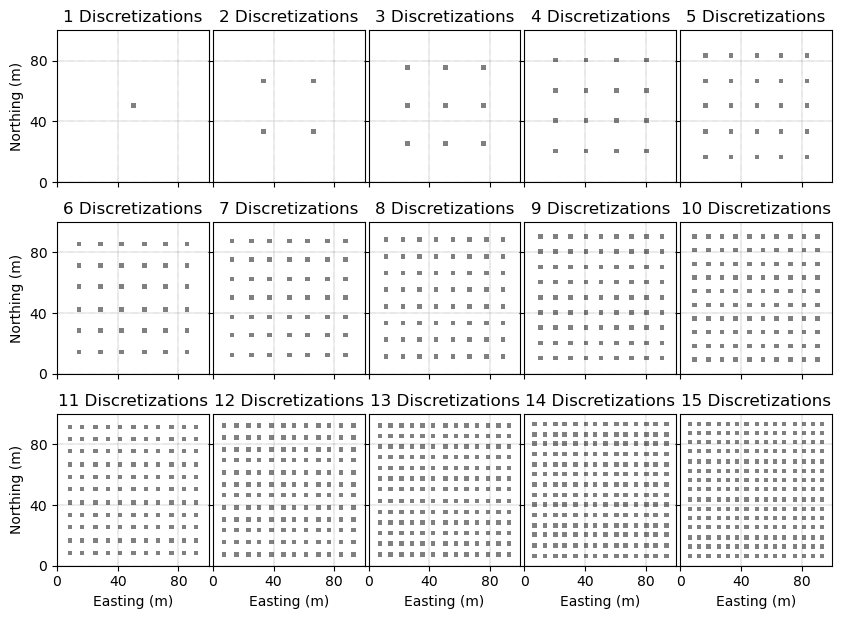

In [25]:
def get_discretized_indices(grid, num_disc):
    """Get the grid indices corresponding with each block discretization

    Wrapped in a function for re-use in later sections
    """
    indices = {}
    ndim = 3  # Determine grid dimension
    if grid.griddef.nz == 1:
        ndim = 1 if (grid.griddef.nv == 1) else 2
    for ndis in range(1, num_disc + 1):
        inds = np.linspace(0,100,ndis+2)[1:-1]
        combinations = list(product(inds, repeat=ndim))
        length = len(combinations)
        ix = [x[0] for x in combinations]
        iy = [x[1] for x in combinations] if ndim > 1 else [0]*length
        iz = [x[2] for x in combinations] if ndim > 2 else [0]*length
        indices[ndis] = grid.griddef.blockoffsets_to_blockindices(ix,iy,iz)
    return indices

num_disc = 15
indices_2d = get_discretized_indices(grid_2d, num_disc)
fig, axes = rmsp.ImageGrid(3, 5, figsize=(10, 10))
for n, ax in zip(indices_2d, axes):
    grid_2d.loc[indices_2d[n]].sectionplot('.5', ax=ax, xlim=(0, 100), ylim=(0, 100),
                                           title=f'{n} Discretizations', block_shrink=3)

## Simulate and sample realizations of the block

Simulation is used to generate 200 realizations of the block (e.g., it's underlying spatial variability at the scale of the data). The block is sampled at the differing discretizations levels before calculating the associated average value. The block error is then calculated as the difference between the sampled average and the true value of the block (average of all simulated discretizations).

In [26]:
def calc_error_realizations(grid, indices, vario_model):
    """Simulate the grid and sample at each discretization level.

    After sampling the simulated block with differing discretizations,
    the associated error E{sampled discretizations} - E{all discretizations}
    is calculated and stored for plotting.

    Wrapped in a function for re-use in later sections
    """
    cache = rmsp.Simulator().uncond_simulate(
        grid, vario_model, seed=515151, reals=200)
    errors = {}
    for ireal, real in cache.iter_realizations():
        real = real.values.flatten()
        ref = real.mean()
        errors[ireal] = {}
        for n, idxs in indices.items():
            errors[ireal][n] = real[idxs].mean() - ref
    return pd.DataFrame.from_dict(errors)

error_2d = calc_error_realizations(grid_2d, indices_2d, vario_model)

## Plot error of individual realizations

The plot below shows the error of 20 realizations as a function of discretization level. More discretization leads to block averages closer to the true underlying value, and thus, lower error.

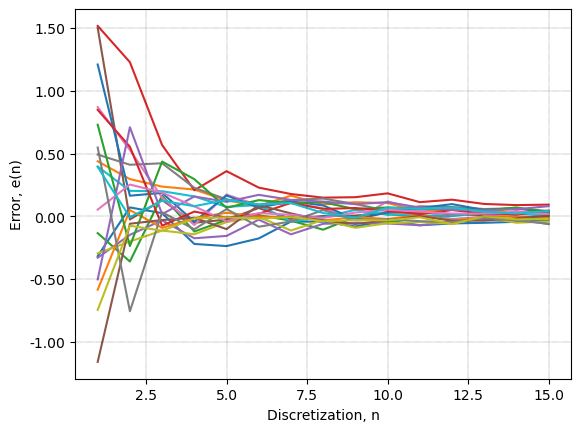

In [27]:
fig, ax = plt.subplots()
df = error_2d.iloc[:, :20]
df.plot(ax=ax, legend=False)
ax.set_xticks(ticks=df.index, labels=df.index)
rmsp.format_plot(ax, 'Discretization, n', 'Error, e(n)')

## MSE over realizations

The mean squared error (MSE) of each discretization level is calculated over the 200 realizations, summarizing how error is expected to reduce with increasing block discretization. Error is shown to stabilize at an acceptable level in proximity to 5x5 discretizations, and grows vanishingly small at 10x10 discretizations.

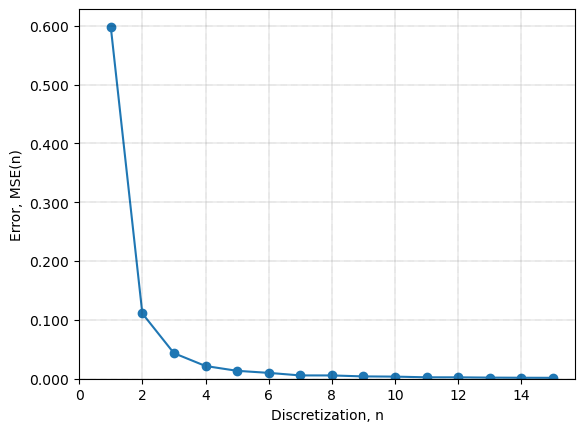

In [28]:
def plot_mse(error, ax, label=None, **kwargs):
    """Plot the mean squared error vs. block discretization level

    Wrapped in a function for re-use in later sections
    """
    mse = (error * error).mean(1)
    mse.plot(marker='o', ax=ax, label=label)
    rmsp.format_plot(ax, 'Discretization, n', 'Error, MSE(n)', **kwargs)
    ax.set_xticks(ticks=np.arange(0, len(mse), 2))

fig, ax = plt.subplots()
plot_mse(error_2d, ax, ylim=(0, None))

---
# Block Dimension vs. Discretization Error

This section examines the effect of block dimension on discretization error. The workflow demonstrated above with a 2D grid (representing a discretized 2D block) is repeated on 1D and 3D grids/blocks.

Begin by creating 1D and 3D grids, placing within a dictionary for iteration that follows:

In [29]:
grids = {
    '1D': rmsp.GridData(
        griddef=rmsp.GridDef(
            xcmin=0.5,
            ycmin=0.5,
            zcmin=0.5,
            usize=1.0,
            vsize=1.0,
            zsize=1.0,
            nu=100,
            nv=1,
            nz=1,
            azimuth_deg=0.0,
            blockindices='full'
        )),
    '3D': rmsp.GridData(
        griddef=rmsp.GridDef(
            xcmin=0.5,
            ycmin=0.5,
            zcmin=0.5,
            usize=1.0,
            vsize=1.0,
            zsize=1.0,
            nu=100,
            nv=100,
            nz=100,
            azimuth_deg=0.0,
            blockindices='full'
        ))
}

Calculate MSE for the 1D and 3D grids, continuing to use a discretization level of up to 15:

In [30]:
errors = {}
for name, grid in grids.items():
    errors[name] = calc_error_realizations(
        grid, get_discretized_indices(grid, num_disc), vario_model)

The plot shows that increasing block dimension leads to a faster reduction of error with increasing discretization:

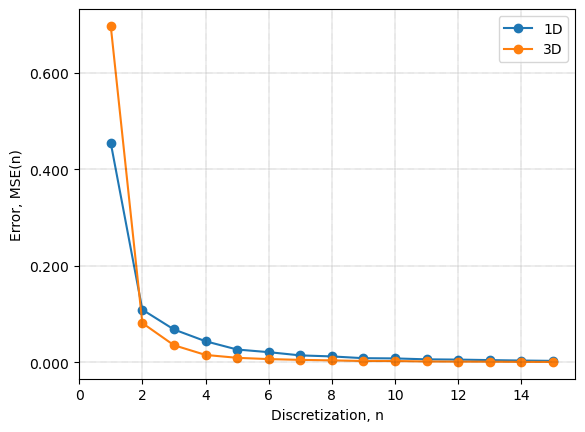

In [31]:
fig, ax = plt.subplots()
for name, error in errors.items():
    plot_mse(error, ax, name)
_ = ax.legend()

---
# Spatial Correlation vs. Discretization Error

The range of the variogram with respect to block size is a factor in choosing the required discretization level. This is studied by simulating the values in the 2D block with a variogram range between 25 to 400m. Bear in mind that the grid extents (representing the block size being discretized) is $(100m)^2$ here.

Initialize the variograms being tested, applying the previously defined variogram parameters with the varying ranges:

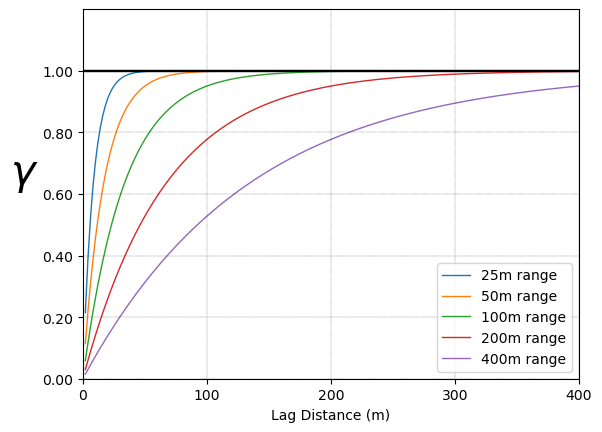

In [32]:
vario_models = {}
fig, ax = plt.subplots()
for vrange in [25, 50, 100, 200, 400]:
    vario_params['ranges'] = [vrange] * 3
    vario_models[vrange] = rmsp.VarioModel.from_params(**vario_params)
    vario_models[vrange].plot(ax=ax, label=f'{vrange}m range', xlim=(0, 400))

_ = ax.legend()

Simulate the grid with each variogram and calculate associated block error with each discretization level:

In [33]:
vario_errors = {vrange: calc_error_realizations(grid_2d, indices_2d, vmodel)
                for vrange, vmodel in vario_models.items()}

The result below shows that the block error decreases with an increasing variogram range at lower discretization levels, although the errors are reasonably similar at discretizations of 4-6. This result would vary with changing block sizes.

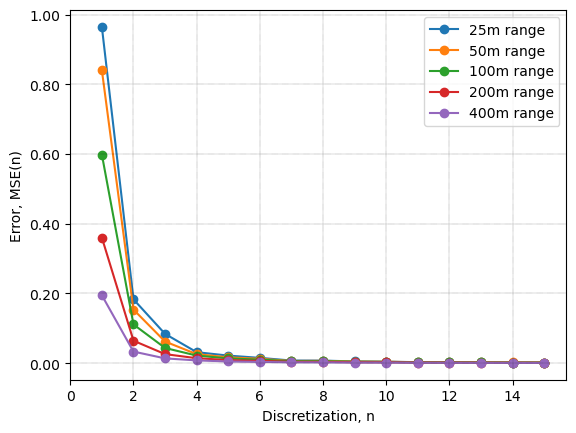

In [34]:
fig, ax = plt.subplots()
for vrange, error in vario_errors.items():
    plot_mse(error, ax, f'{vrange}m range')
_ = ax.legend()

--- 
# Closing Comments

This notebook demonstrates the impact of block discretization applied in estimation. Important factors that influence this decision, including spatial continuity and dimension are also shown. In general, a discretization of 5x5 in 2D and 4x4x4 in 3D has been shown to yield acceptable accuracy. As discussed in the [Geostatistical Lesson](https://geostatisticslessons.com/lessons/discretization), other considerations should also be accounted for when considering block discretization, including composite size in the direction of drilling.

<footer>
<div style="text-align:center">    
    <p style="text-align:center; color:#00797C"> Partners: </p>
    <a href="https://resourcemodelingsolutions.com"><img class="rs" style="max-width:200px;"    src="https://geostatisticslessons.com/images/icons/resource_modeling_solutions_logo.png">
    </a>
    <a  href="https://geostatisticslessons.com/termsofuse"> <p style="text-align:center; color:#00797C">  Terms of Use </p></a>
    <a href="mailto:contact@resmodsol.com"> <p style="text-align:center; color:#00589d">Contact Resource Modeling Solutions about a commercial or academic license for RMSP</p> </a>
</div>
</footer>